In [21]:
from scapy.all import *
import pandas as pd
import numpy as np
import binascii
import matplotlib.pyplot as plt
import datetime
import socket

%matplotlib inline

In [4]:
# pcap to dataframe

pcap = rdpcap("../pcaps/webinar_pcap_compressed_6.pcap")

ip_fields = [field.name for field in IP().fields_desc]
tcp_fields = [field.name for field in TCP().fields_desc]
udp_fields = [field.name for field in UDP().fields_desc]

dataframe_fields = ip_fields + ['time'] + tcp_fields + ['payload','payload_raw','payload_hex']

df = pd.DataFrame(columns=dataframe_fields)
for packet in pcap[IP]:
    field_values = []
    for field in ip_fields:
        if field == 'options':
            field_values.append(len(packet[IP].fields[field]))
        else:
            field_values.append(packet[IP].fields[field])
    
    field_values.append(packet.time)
    
    layer_type = type(packet[IP].payload)
    for field in tcp_fields:
        try:
            if field == 'options':
                field_values.append(len(packet[layer_type].fields[field]))
            else:
                field_values.append(packet[layer_type].fields[field])
        except:
            field_values.append(None)
    
    field_values.append(len(packet[layer_type].payload))
    field_values.append(packet[layer_type].payload.original)
    field_values.append(binascii.hexlify(packet[layer_type].payload.original))
    df_append = pd.DataFrame([field_values], columns=dataframe_fields)
    df = pd.concat([df, df_append], axis=0)

# replace proto values with strings 'tcp' or 'udp'

#df['proto'] = df['proto'].replace([6],'tcp')
#df['proto'] = df['proto'].replace([17],'udp')

df = df.reset_index()
df["len"] = pd.to_numeric(df["len"])
df["time"] = pd.to_numeric(df["len"])

df = df.drop(columns="index")

proto
6     53
17     5
Name: src, dtype: int64


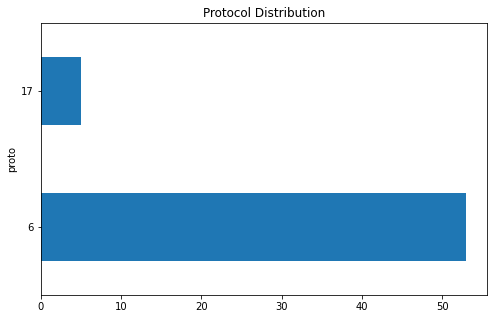

In [5]:
protocol_stats = df.groupby("proto")['src'].count()
print(protocol_stats)
protocol_stats.plot(kind='barh',title="Protocol Distribution",figsize=(8,5))
plt.show()




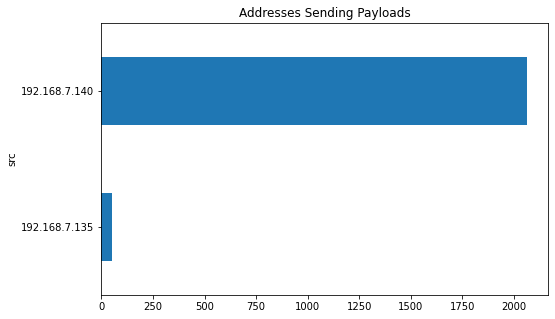

In [6]:
# Graph - Group by Source Address and Payload Sum

source_addresses = df.groupby("src")['payload'].sum()
source_addresses.plot(kind='barh',title="Addresses Sending Payloads",figsize=(8,5))
plt.show()


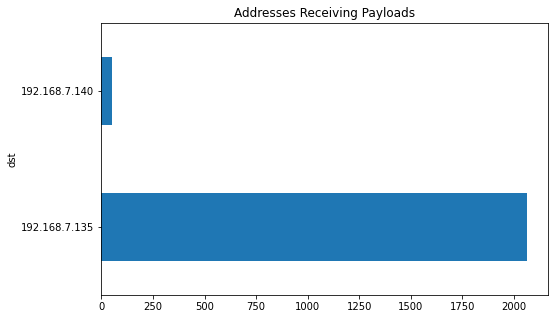

In [7]:
# Graph - Group by Dest Address and Payload Sum

dst_addresses = df.groupby("dst")['payload'].sum()
dst_addresses.plot(kind='barh',title="Addresses Receiving Payloads",figsize=(8,5))
plt.show()


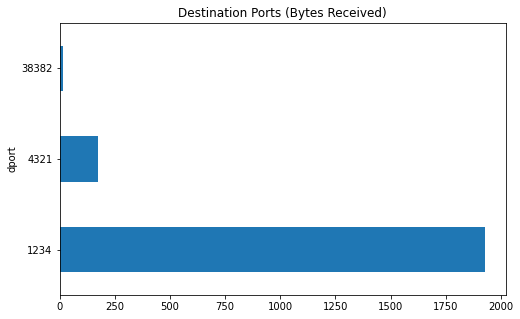

In [8]:
# Graph - Group by Destination Port and Payload Sum

destination_ports = df.groupby("dport")['payload'].sum()
destination_ports.plot(kind='barh',title="Destination Ports (Bytes Received)",figsize=(8,5))
plt.show()


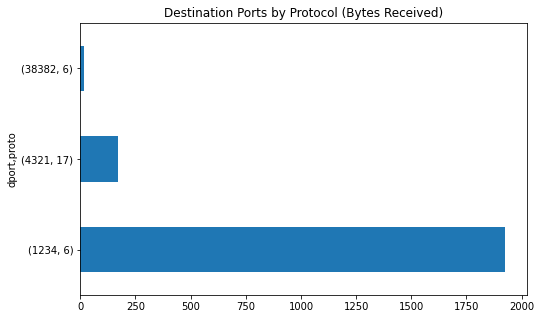

In [9]:
# Graph - Group by Destination Port, Protocol and Payload Sum

destination_payloads_proto = df.groupby(["dport","proto"])['payload'].sum()
destination_payloads_proto.plot(kind='barh',title="Destination Ports by Protocol (Bytes Received)",figsize=(8,5))
plt.show()


In [10]:

# Adding human-readable timestamp column

def return_timestamp(x):
    return datetime.datetime.fromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S.%f')

df['timestamp'] = df['time'].apply(lambda x: (return_timestamp(x)))
df['timestamp'] = pd.to_datetime(df['timestamp'])



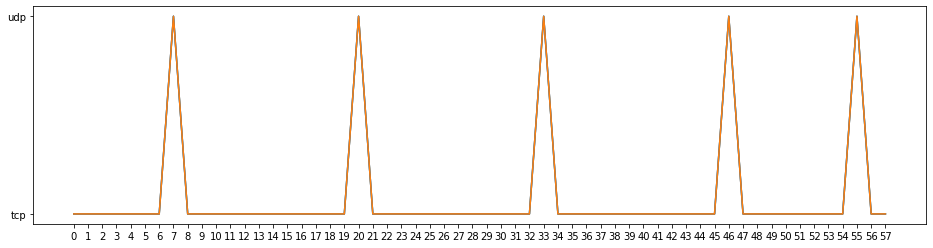

In [11]:
df['proto'].plot(figsize=(16,4))
df['proto'].plot(subplots=True, figsize=(16,4))
df['proto'].plot(y=["proto"], figsize=(16,4))
plt.xticks(df.index)
plt.yticks([6,17],['tcp','udp'])
plt.show()

# Notice the heartbeat packet
# Negotiation changes across runs
# Show this graph for the 3 pcaps

In [12]:
# Visualization across 3 pcaps - helps to see what the fields are


In [13]:
# UDP length statistics
df[df['proto'] == 17].describe()


,len,time
count,5.000000,5.000000
mean,62.400000,62.400000
std,0.894427,0.894427
min,62.000000,62.000000
25%,62.000000,62.000000
50%,62.000000,62.000000
75%,62.000000,62.000000
max,64.000000,64.000000


In [14]:
# TCP length statistics
df[df['proto'] == 6].describe()


,len,time
count,53.000000,53.000000
mean,88.924528,88.924528
std,43.608772,43.608772
min,52.000000,52.000000
25%,52.000000,52.000000
50%,52.000000,52.000000
75%,142.000000,142.000000
max,142.000000,142.000000


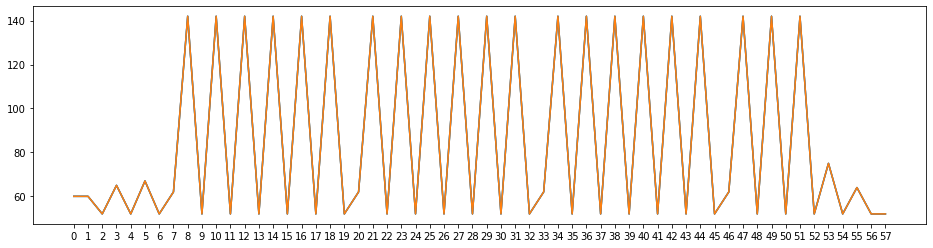

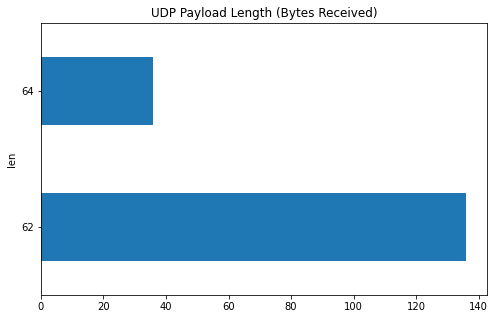

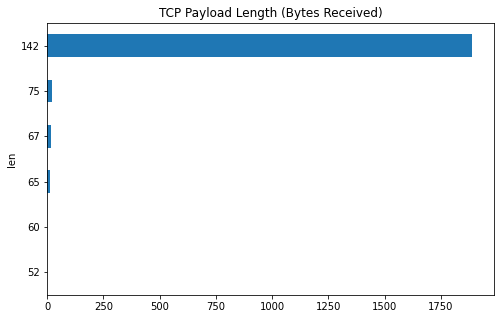

In [15]:
# Packet length visualizations

df['len'].plot(figsize=(16,4))
df['len'].plot(subplots=True, figsize=(16,4))
df['len'].plot(y=['len'], figsize=(16,4))
plt.xticks(df.index)
plt.show()

# UDP length 

udp_df = df[df['proto'] == 17]
destination_ports = udp_df.groupby("len")['payload'].sum()
destination_ports.plot(kind='barh',title="UDP Payload Length (Bytes Received)",figsize=(8,5))
plt.show()

# TCP length

udp_df = df[df['proto'] == 6]
destination_ports = udp_df.groupby("len")['payload'].sum()
destination_ports.plot(kind='barh',title="TCP Payload Length (Bytes Received)",figsize=(8,5))
plt.show()

# TCP segment size by IP address

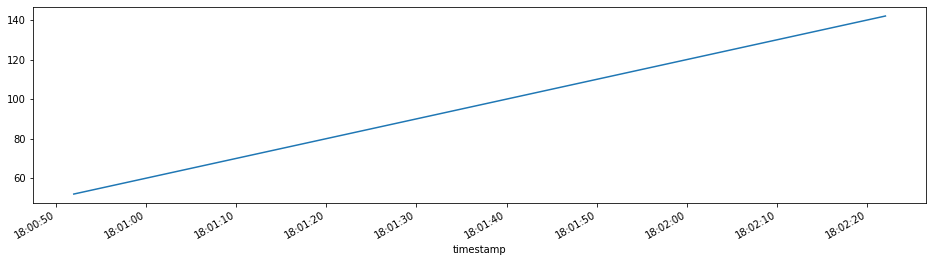

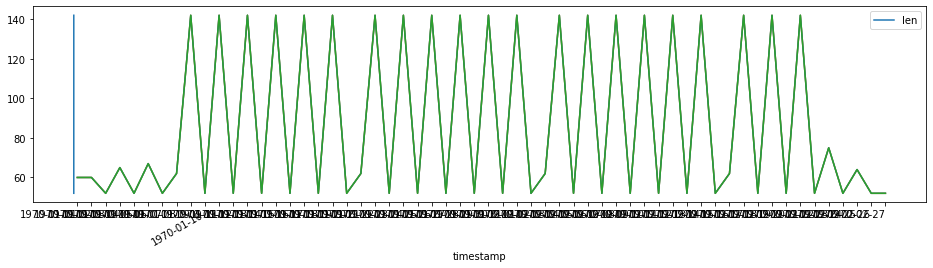

In [16]:
# Create a new index by timestamp 

df_indexed = df.set_index('timestamp')
df_indexed['len'].plot(figsize=(16,4))
df_indexed.plot(y='len')

df['len'].plot(figsize=(16,4))
df['len'].plot(subplots=True, figsize=(16,4))
df['len'].plot(y=['len'], figsize=(16,4))
plt.xticks(df.index)
plt.show()




In [17]:
# Geocoordinates from several pcaps - payload


In [33]:
# Splitting the payload column into sets of two characters, and add them to new column

def return_list_of_bytes(x,n):
    return [x[index : index + n] for index in range(0, len(x), n)]

df['payload_array_raw'] = df['payload_raw'].apply(lambda x: return_list_of_bytes(x,4))

df['payload_array_raw'].iloc[10][0]

b'\xc0\xa8\x07\x8c'

In [41]:
# Search IP in payload - visualization
import socket

matchIps = []
packetIps = [] 

    # Convert an IP string to long
def long2ip(ip):
    return socket.inet_ntoa(ip)

#take a list of bytes strings
def searchPayload(payload):
    payloadIps = []
    for p in payload:
        if len(p) % 4  == 0 and p != b'':
            ip = long2ip(p)
            payloadIps.append(ip)
    return payloadIps

df['payload_ips'] = df['payload_array_raw'].apply(lambda x: searchPayload(x))




In [42]:
df

,version,ihl,tos,len,id,flags,frag,ttl,proto,chksum,...,chksum,urgptr,options,payload,payload_raw,payload_hex,timestamp,payload_array,payload_array_raw,payload_ips
0,4,5,0,60,8180,DF,0,64,6,35428,...,37010,0,5,0,b'',b'',1969-12-31 18:01:00,[],[],[]
1,4,5,0,60,0,DF,0,64,6,43608,...,2653,0,5,0,b'',b'',1969-12-31 18:01:00,[],[],[]
2,4,5,0,52,8181,DF,0,64,6,35435,...,37002,0,3,0,b'',b'',1969-12-31 18:00:52,[],[],[]
3,4,5,0,65,8182,DF,0,64,6,35421,...,37015,0,3,13,b'\xc0\xa8\x07\x8c\x00\x01\x00\x05\x16\xce\xb0...,b'c0a8078c0001000516ceb0f1ef',1969-12-31 18:01:05,"[b'c0a8078c', b'00010005', b'16ceb0f1', b'ef']","[b'\xc0\xa8\x07\x8c', b'\x00\x01\x00\x05', b'\...","[192.168.7.140, 0.1.0.5, 22.206.176.241]"
4,4,5,0,52,55322,DF,0,64,6,53829,...,11730,0,3,0,b'',b'',1969-12-31 18:00:52,[],[],[]
5,4,5,0,67,55323,DF,0,64,6,53813,...,43198,0,3,15,b'\xc0\xa8\x07\x87\x00\x02\x00\x05\x16\xce\xb0...,b'c0a807870002000516ceb0f1ef0006',1969-12-31 18:01:07,"[b'c0a80787', b'00020005', b'16ceb0f1', b'ef00...","[b'\xc0\xa8\x07\x87', b'\x00\x02\x00\x05', b'\...","[192.168.7.135, 0.2.0.5, 22.206.176.241]"
6,4,5,0,52,8183,DF,0,64,6,35433,...,37002,0,3,0,b'',b'',1969-12-31 18:00:52,[],[],[]
7,4,5,0,62,1,,0,64,17,59978,...,6292,None,None,34,b'\xc0\xa8\x07\x8c\x00\x03\x00\x00\x00\x05\x16...,b'c0a8078c00030000000516ceb0f1ef000e36332e322c...,1969-12-31 18:01:02,"[b'c0a8078c', b'00030000', b'000516ce', b'b0f1...","[b'\xc0\xa8\x07\x8c', b'\x00\x03\x00\x00', b'\...","[192.168.7.140, 0.3.0.0, 0.5.22.206, 176.241.2..."
8,4,5,0,142,8184,DF,0,64,6,35342,...,37092,0,3,90,b'\xc0\xa8\x07\x8c\x00\x04\x00\x15\x00N\x1f\x8...,b'c0a8078c00040015004e1f8b080092c1aa5f0003ed59...,1969-12-31 18:02:22,"[b'c0a8078c', b'00040015', b'004e1f8b', b'0800...","[b'\xc0\xa8\x07\x8c', b'\x00\x04\x00\x15', b'\...","[192.168.7.140, 0.4.0.21, 0.78.31.139, 8.0.146..."
9,4,5,0,52,55324,DF,0,64,6,53827,...,11139,0,3,0,b'',b'',1969-12-31 18:00:52,[],[],[]


['192.168.7.140',
 '0.1.0.5',
 '22.206.176.241',
 '192.168.7.135',
 '0.2.0.5',
 '22.206.176.241',
 '192.168.7.140',
 '0.3.0.0',
 '0.5.22.206',
 '176.241.239.0',
 '14.54.51.46',
 '50.44.49.51',
 '49.46.53.49',
 '54.54.55.0',
 '192.168.7.140',
 '0.4.0.21',
 '0.78.31.139',
 '8.0.146.193',
 '170.95.0.3',
 '237.89.221.79',
 '220.70.16.231',
 '53.15.252.15',
 '22.15.85.35',
 '245.176.119.189',
 '107.159.169.99',
 '201.248.124.119',
 '110.252.113.178',
 '239.8.84.85',
 '43.68.81.64',
 '1.18.5.82',
 '120.168.250.183',
 '119.119.103.191',
 '184.47.32.9',
 '42.149.110.121',
 '216.185.153.223',
 '204.206.236.204',
 '192.168.7.140',
 '0.4.0.20',
 '0.78.126.153',
 '179.139.208.61',
 '189.59.190.252',
 '116.113.138.119',
 '239.46.47.182',
 '158.161.121.172',
 '133.148.242.30',
 '133.212.179.123',
 '78.18.202.104',
 '228.7.216.247',
 '131.192.243.241',
 '150.135.48.33',
 '116.203.241.158',
 '195.153.249.246',
 '229.250.230.248',
 '179.227.108.125',
 '56.190.56.95',
 '135.123.72.254',
 '63.109.113.58'